In [1]:
import numpy as np
np.random.seed(210187)
import matplotlib.pyplot as plt

from scipy.stats import uniform, norm

In [2]:
# obs range
xrange = (3,3.5)

# true pars
mu = 3.25
sg = 0.05
fr = 0.1
Nevs = 500

# models
def smodel(x, mu, sg):
    return norm.pdf(x, mu, sg)

def bmodel(x):
    return uniform.pdf(x, xrange[0], xrange[1]-xrange[0])

def model(x, f, mu, sg):
    return f*smodel(x,mu,sg) + (1-f)*bmodel(x)

def density(x, Ns, mu, sg, Nb):
    return Ns+Nb, Ns*smodel(x,mu,sg) + Nb*bmodel(x)


In [3]:
def generate(Ns, mu, sg, Nb, poiss=True):
    smodel = norm(mu,sg)
    bmodel = uniform(xrange[0], xrange[1]-xrange[0])
    
    if poiss:
        Ns = np.random.poisson( Ns )
        Nb = np.random.poisson( Nb )

    bevs = bmodel.rvs(size=Nb)
    sevs = smodel.rvs(size=Ns)

    dset = np.concatenate([bevs,sevs])
    
    return dset
    
    

In [4]:
dset = generate( Ns=fr*Nevs, mu=mu, sg=sg, Nb=(1-fr)*Nevs )

In [5]:
# write a fitting function
from iminuit import cost, Minuit

# note that I fit twice (once with the background only hypothesis 
# and once with the signal+background hypothesis with the signal floating)

# what I return is the log likelihood ratio (i.e. the Neyman-Pearson test statistic)

def fit(dset, verbose=False):
    nll = cost.ExtendedUnbinnedNLL(dset, density)
    mi = Minuit(nll, Ns=fr*Nevs, mu=mu, sg=sg, Nb=(1-fr)*Nevs)
    mi.limits['Ns','Nb'] = (0,3*Nevs)
    mi.limits['mu'] = xrange
    mi.limits['sg'] = (0,0.5)

    # free fit
    mi.migrad()
    mi.hesse()
    sb_nll = mi.fval
    sb_vals = list(mi.values)
    if verbose:
        print(mi)

    # b-only fit
    mi.values['Ns'] = 0
    mi.fixed['Ns','mu','sg'] = True
    mi.migrad()
    mi.hesse()
    bo_nll = mi.fval
    bo_vals = list(mi.values)
    if verbose:
        print(mi)
        
    n2ll = -2*(sb_nll-bo_nll)
     
    return n2ll, sb_vals, bo_vals


In [6]:
T0, sb_vals, bo_vals = fit(dset)

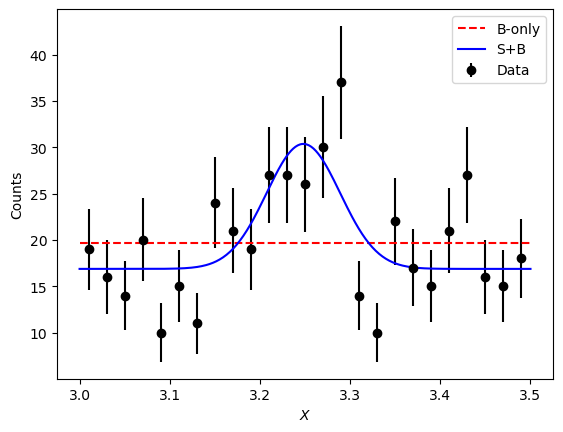

In [7]:
# write a plotting function to check it looks ok
def plot(dset, sb_vals, bo_vals):
    
    fig, ax = plt.subplots()
    nh, xe = np.histogram(dset, bins=25)
    cx = 0.5*(xe[:-1]+xe[1:])
    bw = xe[1]-xe[0]
    
    ax.errorbar(cx, nh, nh**0.5, fmt='ko', label='Data')
    
    x = np.linspace(*xrange, 400)
    
    ax.plot( x, bw*density(x, *bo_vals)[1], 'r--', label='B-only' )
    ax.plot( x, bw*density(x, *sb_vals)[1], 'b-' , label='S+B')
    
    ax.legend()
    
    ax.set_xlabel('$X$')
    ax.set_ylabel('Counts')
    
plot(dset, sb_vals, bo_vals)

In [8]:
from tqdm import tqdm
ntoys = 2000
gen_vals = sb_vals
sb_test_stats = []
for i in tqdm(range(ntoys)):
    toy = generate(*gen_vals) 
    ll, sb, bo = fit(toy)
    sb_test_stats.append(ll)
    

100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 81.24it/s]


Text(0.5, 0, '$T$')

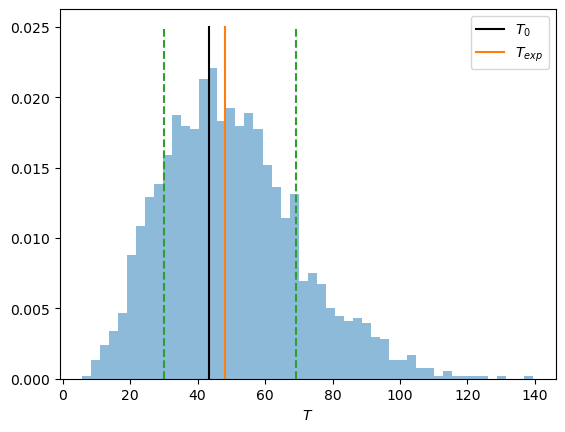

In [9]:
# find expected point and band
from scipy.stats import chi2
Tsb_exp = np.median( sb_test_stats)
qlow = (1-chi2.cdf(1,1))/2
qup = 1-qlow
Tsb_low, Tsb_up = np.quantile( sb_test_stats, [qlow, qup] )

plt.hist(sb_test_stats, density=True, bins=50, alpha=0.5)
plt.plot( [T0, T0], [0,0.025], label='$T_0$', c='k')
plt.plot( [Tsb_exp, Tsb_exp], [0, 0.025], label='$T_{exp}$' )
plt.plot( [Tsb_low, Tsb_low], [0, 0.025], c='C2', ls='--')
plt.plot( [Tsb_up, Tsb_up], [0, 0.025], c='C2', ls='--')
plt.legend()
plt.xlabel('$T$')

In [10]:
from tqdm import tqdm
ntoys = 2000
gen_vals = bo_vals
bo_test_stats = []
for i in tqdm(range(ntoys)):
    toy = generate(*gen_vals) 
    ll, sb, bo = fit(toy)
    bo_test_stats.append(ll)
    
# find expected point and band
Tbo_exp = np.median( bo_test_stats)
qlow = (1-chi2.cdf(1,1))/2
qup = 1-qlow
Tbo_low, Tbo_up = np.quantile( bo_test_stats, [qlow, qup] )

    

100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.37it/s]


Text(0.5, 0, '$T$')

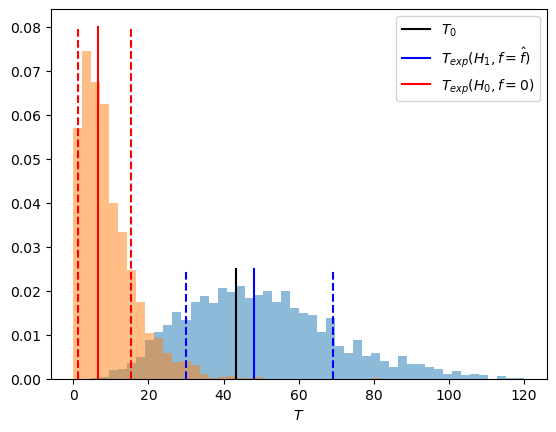

In [11]:
x = np.linspace(0,140,200)

plt.hist(sb_test_stats, density=True, bins=50, range=(0,120), alpha=0.5)
plt.plot( [T0, T0], [0,0.025], label='$T_0$', c='k')
plt.plot( [Tsb_exp, Tsb_exp], [0, 0.025], c='b', label='$T_{exp}(H_1, f=\hat{f})$' )
plt.plot( [Tsb_low, Tsb_low], [0, 0.025], c='b', ls='--')
plt.plot( [Tsb_up, Tsb_up], [0, 0.025], c='b', ls='--')
plt.plot( [Tbo_exp, Tbo_exp], [0, 0.08], c='r', label='$T_{exp}(H_0, f=0)$' )
plt.plot( [Tbo_low, Tbo_low], [0, 0.08], c='r', ls='--')
plt.plot( [Tbo_up, Tbo_up], [0, 0.08], c='r', ls='--')
plt.hist(bo_test_stats, density=True, bins=50, range=(0,120), alpha=0.5)

plt.legend()
plt.xlabel('$T$')

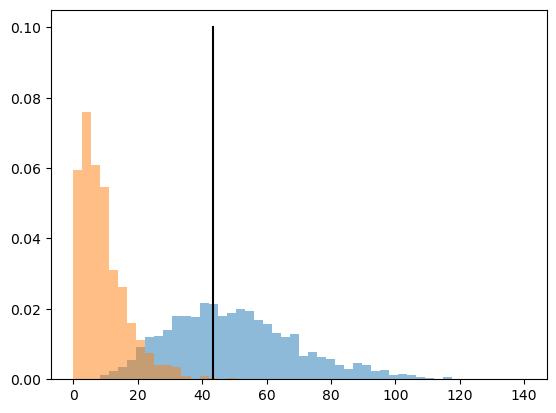

In [12]:
plt.hist(sb_test_stats, density=True, bins=50, range=(0,140), alpha=0.5)
plt.hist(bo_test_stats, density=True, bins=50, range=(0,140), alpha=0.5)
plt.plot( [T0, T0], [0,0.1], label='$T_0$', c='k')

In [13]:
sb_test_stats = np.asarray( sb_test_stats )
bo_test_stats = np.asarray( bo_test_stats )
CLsb = len( sb_test_stats[sb_test_stats < T0] ) / 2000
CLb  = len( bo_test_stats[bo_test_stats < T0] ) / 2000

CLs = CLsb / CLb
print('CLsb:', CLsb)
print('CLb: ', CLb )
print('CLs: ', CLs)

CLsb: 0.4035
CLb:  0.9975
CLs:  0.4045112781954887
